<a href="https://colab.research.google.com/github/MitraG/Disaster-Response-Classification-Project/blob/main/phase-2-notebooks/Ocean_Health_Index_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install xarray
import matplotlib
import pandas as pd

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving scores.csv to scores.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['scores.csv']))
# Dataset is now stored in a Pandas Dataframe
#Show dataset
df.head()

,scenario,goal,long_goal,dimension,region_id,region_name,value
0,2012,AO,Artisanal opportunities,future,0,Global average,74.59
1,2012,AO,Artisanal opportunities,future,1,Cocos Islands,71.39
2,2012,AO,Artisanal opportunities,future,2,Christmas Island,71.39
3,2012,AO,Artisanal opportunities,future,3,Norfolk Island,41.93
4,2012,AO,Artisanal opportunities,future,4,Macquarie Island,NaN


# Analysis Goal
Now that the data has been stored as a dataframe, the table will be filters to show data for Portugal only. https://oceanhealthindex.org/regions/portugal/
After filtering the table, in depth analysis will be done to understand OHI's methodology in calculating the index, and see if this is something we can use for our modelling. 

In [ ]:
#Showing the data types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268026 entries, 0 to 268025
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   scenario     268026 non-null  int64  
 1   goal         268026 non-null  object 
 2   long_goal    268026 non-null  object 
 3   dimension    268026 non-null  object 
 4   region_id    268026 non-null  int64  
 5   region_name  268026 non-null  object 
 6   value        237014 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 14.3+ MB


##Clean and filter data


In [ ]:
#Filter data to only show indexes for Portugal
df_portugal = df[df.region_id == 183]
#Drop irrelevant columns
df_portugal = df_portugal.drop(['region_name', 'region_id'], axis=1)
df_portugal = df_portugal.rename(columns={'scenario': 'year', 'value': 'individual score'})
df_portugal.head()

,year,goal,long_goal,dimension,value
172,2012,AO,Artisanal opportunities,future,72.79
393,2012,AO,Artisanal opportunities,pressures,23.95
614,2012,AO,Artisanal opportunities,resilience,78.44
836,2012,AO,Artisanal opportunities,score,75.30
1058,2012,AO,Artisanal opportunities,status,77.81


In [ ]:
df_portugal[(df_portugal.year==2020)].sample(n=10, random_state=1)

,year,goal,long_goal,dimension,value
214814,2020,NP,Natural products,score,78.90
204845,2020,FP,Food provision,resilience,NaN
207503,2020,ICO,Iconic species (subgoal),resilience,76.74
213042,2020,MAR,Mariculture (subgoal),pressures,27.38
210384,2020,LIV,Livelihoods,pressures,28.97
217472,2020,SPP,Species condition (subgoal),score,73.02
216586,2020,SP,Sense of place,trend,0.01
207947,2020,ICO,Iconic species (subgoal),status,58.00
202852,2020,ECO,Economies,trend,0.09
203516,2020,FIS,Fisheries (subgoal),resilience,72.43


###Understanding OHI
The flowerpot diagram below shows how the OHI is generally calculated. The scores for each category is averaged out to make the regional score in the middle. 
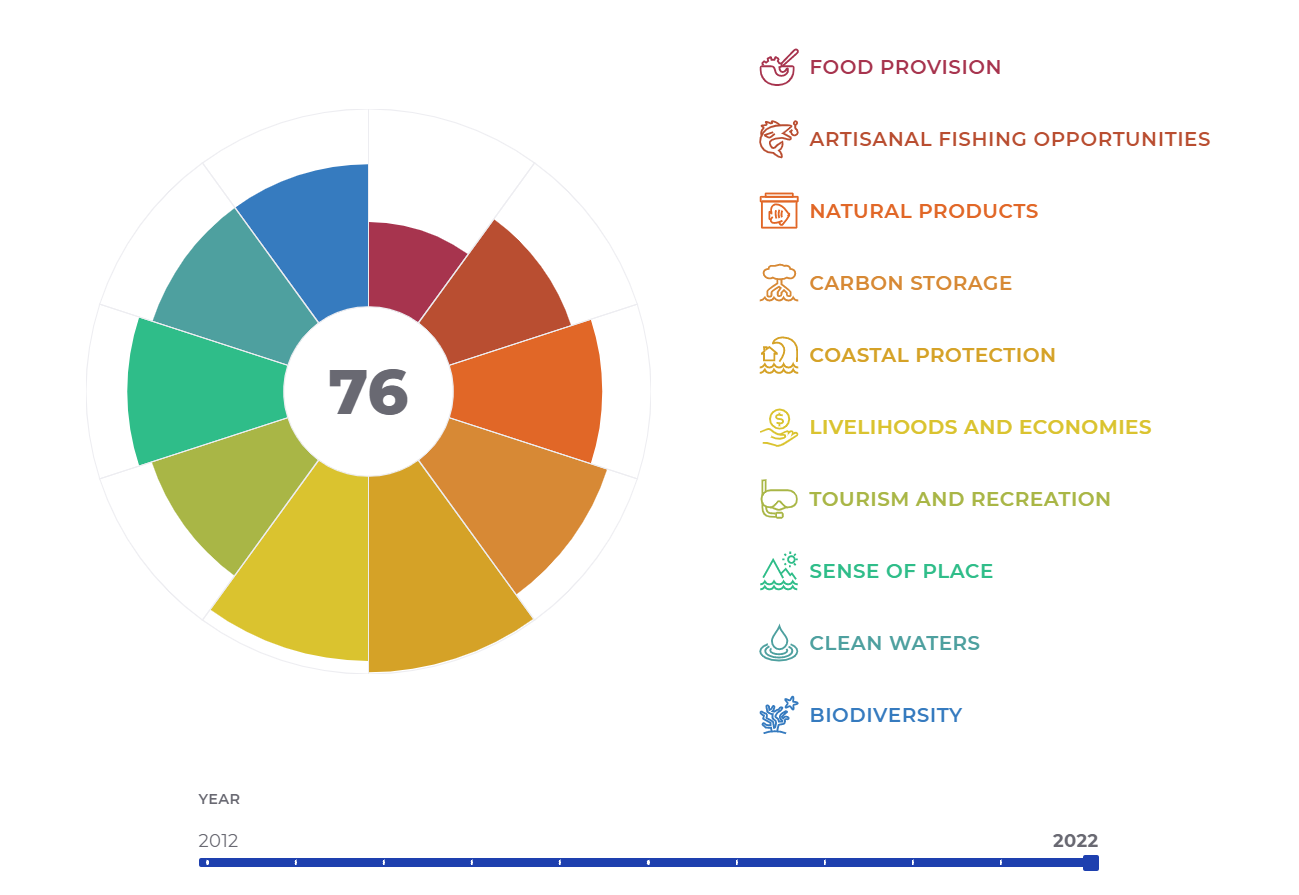

Goal Scores are based on several components: current status, likely future status, trend, pressures, and resilience.

To calculate each Goal Score we average the Present Status and Likely Future Status:

CURRENT STATUS is a goal’s current value compared to its reference point, resulting in a score from 0 to 100.

LIKELY FUTURE STATUS is the predicted status score five years into the future (once again, on a scale from 0 to 100), which is estimated by adjusting the current status score by 3 variables:

TREND which is the change in a goal’s status observed over the most recent five years.
PRESSURES which are the ecological and social factors that decrease a goal’s status.
RESILIENCE which are ecological factors and social initiatives (policies, laws, etc) that mitigate the pressures acting on a goal.

Data dictionary: https://oceanhealthindex.org/images/htmls/Supplement.html#2_The_Theory_of_OHI
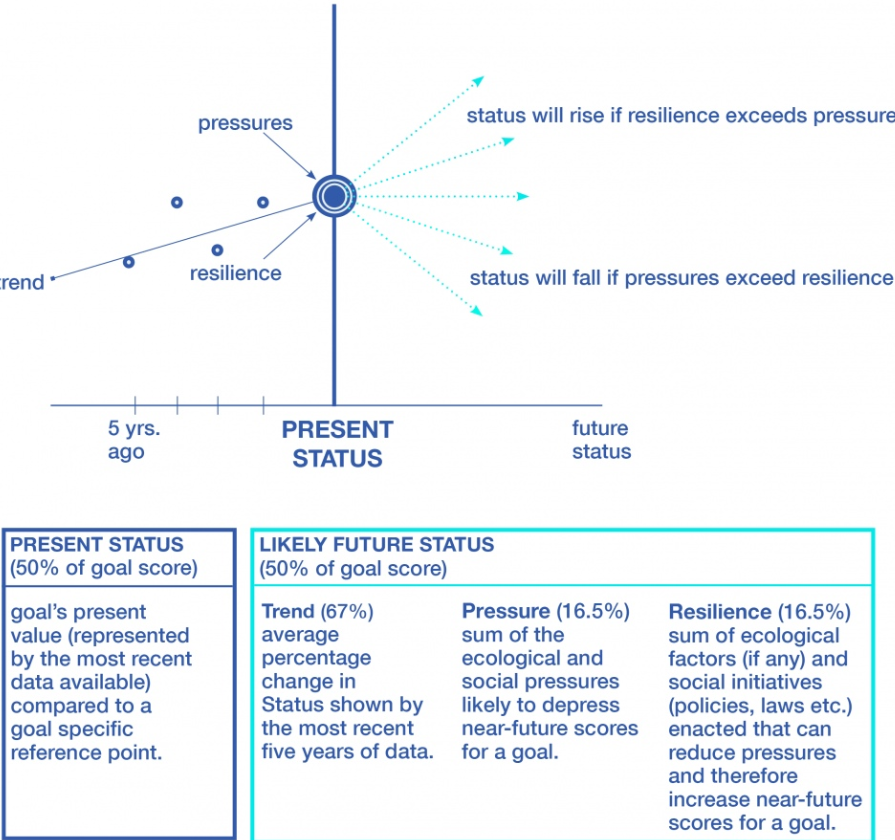

The 10 goals that comprise the global Ocean Health Index were based on extensive study by scientists, economists, and sociologists. However, the OHI framework is flexible and can be used to assess ocean health in different contexts, and the goals included in other OHI assessments may differ depending on local context.

To prep for feature selection, the aim is to verify that biodiversity and tourism are ideal goals for our model. 

Considering that the time range of this data is 2012-2022, there should be 11 rows for each dimension within a category in long_goal. Below is  a brief analysis on the frequencies and unique values in the 'long goal' and 'dimension' columns. 

In [ ]:
#Understanding unique values within dataset
#Goals column
print('There are' , df_portugal['long_goal'].nunique(), 'unique values listed in the dataset')
print('The categories in the goals column are', df_portugal.long_goal.unique())
#Dimensions column
print('There are' , df_portugal['dimension'].nunique(), 'unique dimensions listed in the dataset')
print('The dimensions in this dataset are', df_portugal.dimension.unique())

There are 19 unique goals listed in the dataset
The categories in the goals column are ['Artisanal opportunities' 'Biodiversity' 'Coastal protection'
 'Carbon storage' 'Clean water' 'Economies' 'Fisheries (subgoal)'
 'Food provision' 'Habitat (subgoal)' 'Iconic species (subgoal)' 'Index'
 'Livelihoods & economies' 'Livelihoods'
 'Lasting special places (subgoal)' 'Mariculture (subgoal)'
 'Natural products' 'Sense of place' 'Species condition (subgoal)'
 'Tourism & recreation']
There are 6 unique dimensions listed in the dataset
The dimensions in this dataset are ['future' 'pressures' 'resilience' 'score' 'status' 'trend']


Index is not a goal, rather it represents the Ocean Health Index score.

In [ ]:
#Print the dimensions within the category 'Index' and their respective frequencies
df_p_index = df_portugal[df_portugal.long_goal =='Index']
df_p_index.groupby(['long_goal', 'dimension']).size()

long_goal  dimension
Index      future       11
           score        11
dtype: int64

In [ ]:
#Taking the biodiversity goal to understand the structure to each dimension
#Print the dimensions within the category 'Biodiversity' and their respective frequencies
df_portugal[df_portugal.long_goal == 'Biodiversity'].groupby(['long_goal', 'dimension']).size()

long_goal     dimension 
Biodiversity  future        11
              pressures     11
              resilience    11
              score         11
              status        11
              trend         11
dtype: int64

In [ ]:
#Taking a subgoal in Biodiversity to understand the structure of a subgoal to each dimension
#Print the dimensions within the category 'Habitat' and their respective frequencies
df_portugal[df_portugal.long_goal == 'Habitat (subgoal)'].groupby(['long_goal', 'dimension']).size()

long_goal          dimension 
Habitat (subgoal)  future        11
                   pressures     11
                   resilience    11
                   score         11
                   status        11
                   trend         11
dtype: int64